In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import seaborn as sns
import uproot as ur
import pandas as pd

from os import listdir, mkdir, getcwd
from os.path import isfile, join, basename, isdir

from sys import platform
if platform == "linux" or platform == "linux2":
    import ROOT
    %jsroot off

#from convert_directory import convert_directory

In [2]:
source_path = getcwd() # "/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/ZHH/"
output_path = join(source_path, ".npy")
in_file_location = "hGen"

In [3]:
type_map = {
    "int32_t": "i4"
}

def convert_type(type_name: str):
    if type_name in type_map:
        return type_map[type_name]
    else:
        return type_name

def convert_file(source_path, in_file_location, output_path = ""):
    with ur.open(source_path) as file:
        # Find data in file
        data = file[in_file_location]

        # Get correct column names and types for conversion
        dtype_arr = []
        dtype_names = data.typenames()

        for field_name in dtype_names:
            dtype_arr.append((field_name, convert_type(dtype_names[field_name])))

        # Convert data to (column-wise) arrays using numpy
        out = np.zeros(data.num_entries, dtype=dtype_arr)
        keys = data.keys()
        for i in range(0, len(keys)):
            key = keys[i]
            out[key] = data[key].array()

        if output_path != "":
            np.save(output_path, out, allow_pickle=True)

    return out

# See https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.iterate.html
def convert_directory(source_path: str, in_file_location: str, output_dir_abs: str = ""):
    dir_contents = listdir(source_path)
    root_files = filter(lambda filename: filename.endswith(".root"), dir_contents)

    output_dir = source_path
    if output_dir_abs != "":
        output_dir = output_dir_abs

    if not isdir(output_dir_abs):
        mkdir(output_dir_abs)

    for filename in root_files:
        bname = basename(filename)
        output_path = join(output_dir, bname + ".npy")
        if isfile(output_path):
            print("Skipping file <" + bname + "> (exists)")
        else:
            convert_file(join(source_path, filename), in_file_location, output_path)


convert_directory(source_path, "dataTree", output_path)

In [4]:
# Splits a dataframe with separate columns for reco and true properties to one with the properties and a different label "type" with values "true" and "reco" 
def split_event_tree(df,
                     properties=["sigma", "sigmall", "sigmalr", "sigmarl", "sigmarr", "mz", "mhh", "mzhh", "phi", "phif", "phih", "costheta", "costhetaf", "costhetah"],
                     props_shared=["run", "event", "passed_preselection", "m_true_h1_decay_pdg", "m_true_h2_decay_pdg"],
                     type_names=["true", "reco"], column_concat: str ="_"):
    #type_dict = {}
    #for property in properties:
    #    type_dict[property] = pd.Series(dtype=df.dtypes[type_names[0] + column_concat + property])

    # Rename
    rename_dict = {}
    for property in properties:
        rename_dict[type_names[0] + column_concat + property] = property

    df = df.rename(columns=rename_dict)
    df["type"] = type_names[0]

    # Slice and re-add
    for type in type_names:
        if type == type_names[0]:
            continue

        #column_names = [word.replace(type + column_concat, "") for word in ["asd_123", "asd_345"]]
        props_type_specific = list(map(lambda cn: type+column_concat+cn, properties))
        props_slice = props_shared + props_type_specific
        sliced = df.loc[:, props_slice]

        df.drop(columns=props_type_specific, inplace=True)

        rename_dict = {}
        for property in properties:
            rename_dict[type + column_concat + property] = property

        sliced.rename(columns=rename_dict, inplace=True)
        sliced["type"] = type

        df = pd.concat([df, sliced])

    df.reset_index(drop=True, inplace=True)

    return df

In [5]:
b = list(map(lambda e: join(output_path, e), listdir(output_path)))
b

['c:\\DevRepositories\\ZHH\\.npy\\zhh_output.root.npy']

In [6]:
data = pd.DataFrame(np.load(b[0], allow_pickle=True))
data.columns

Index(['run', 'event', 'passed_preselection', 'passed_validitycheck',
       'm_true_h1_decay_pdg', 'm_true_h2_decay_pdg', 'true_sigma',
       'true_sigmall', 'true_sigmalr', 'true_sigmarl', 'true_sigmarr',
       'true_sigma_p1', 'true_sigmall_p1', 'true_sigmalr_p1',
       'true_sigmarl_p1', 'true_sigmarr_p1', 'true_sigma_p2',
       'true_sigmall_p2', 'true_sigmalr_p2', 'true_sigmarl_p2',
       'true_sigmarr_p2', 'true_sigma_p3', 'true_sigmall_p3',
       'true_sigmalr_p3', 'true_sigmarl_p3', 'true_sigmarr_p3', 'true_mz',
       'true_mhh', 'true_mzhh', 'true_phi', 'true_phif', 'true_phih',
       'true_costheta', 'true_costhetaf', 'true_costhetah', 'true_l1_e',
       'true_l1_px', 'true_l1_py', 'true_l1_pz', 'true_l2_e', 'true_l2_px',
       'true_l2_py', 'true_l2_pz', 'true_h1_e', 'true_h1_px', 'true_h1_py',
       'true_h1_pz', 'true_h2_e', 'true_h2_px', 'true_h2_py', 'true_h2_pz',
       'reco_sigma', 'reco_sigmall', 'reco_sigmalr', 'reco_sigmarl',
       'reco_sigmarr', 'rec

In [7]:
data.dtypes

run                       int32
event                     int32
passed_preselection       int32
passed_validitycheck      int32
m_true_h1_decay_pdg       int32
                         ...   
reco_h1_pz              float64
reco_h2_e               float64
reco_h2_px              float64
reco_h2_py              float64
reco_h2_pz              float64
Length: 81, dtype: object

In [8]:
data.shape

(19900, 81)

In [9]:
data_split = split_event_tree(data)
data_split

,run,event,passed_preselection,passed_validitycheck,m_true_h1_decay_pdg,m_true_h2_decay_pdg,sigma,sigmall,sigmalr,sigmarl,...,reco_l2_pz,reco_h1_e,reco_h1_px,reco_h1_py,reco_h1_pz,reco_h2_e,reco_h2_px,reco_h2_py,reco_h2_pz,type
0,403001,1,1,1.0,5,5,8.215717e-14,3.552943e-15,7.860422e-14,7.876372e-14,...,57.674099,159.701309,-53.189190,-85.131119,-58.362419,155.137085,80.120598,21.679317,48.032017,true
1,403001,2,1,1.0,21,5,2.070080e-13,2.042705e-13,2.737472e-15,2.752175e-15,...,31.627174,144.874069,-94.977203,-45.061089,1.964425,166.988388,29.101830,43.948925,-59.798523,true
2,403001,3,1,1.0,5,5,4.440283e-14,1.842408e-14,2.597875e-14,2.596317e-14,...,77.388412,189.816620,-48.447956,-38.605350,-121.416519,138.691849,63.383865,60.037914,13.117458,true
3,403001,4,1,1.0,5,24,7.102882e-16,7.092752e-16,1.012994e-18,1.001357e-18,...,70.503075,201.624985,-63.263470,48.087894,-133.307816,172.478394,55.739521,-32.105114,63.544586,true
4,403001,5,1,1.0,5,5,1.534941e-15,1.376326e-17,1.521178e-15,1.520468e-15,...,8.898979,165.584702,28.305923,-5.986417,122.540741,144.693024,-10.573847,-47.679798,-74.672890,true
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39795,403001,19896,0,NaN,5,5,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,reco
39796,403001,19897,1,NaN,21,4,2.701024e-14,3.378885e-15,2.363136e-14,2.363237e-14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,reco
39797,403001,19898,1,NaN,5,5,4.682244e-14,7.227006e-16,4.609974e-14,4.612023e-14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,reco
39798,403001,19899,0,NaN,5,5,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,reco


[Text(0.5, 1.0, 'Invalid sigma')]

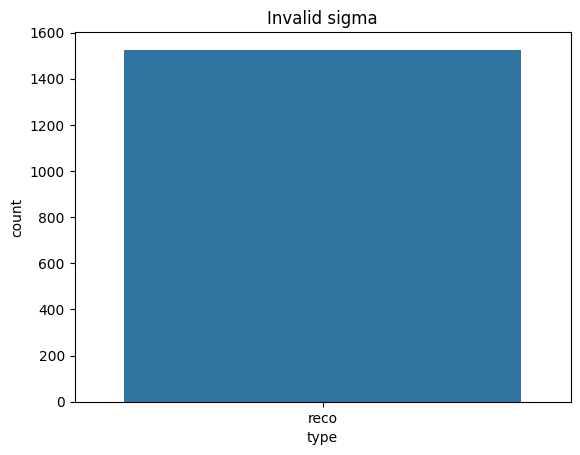

In [10]:
# Invalid sigma
f = sns.countplot(data=data_split[(data_split["sigma"] == 0)], x="type")
f.set(title="Invalid sigma")

[Text(0.5, 1.0, 'Passed pre-selection, but invalid sigma')]

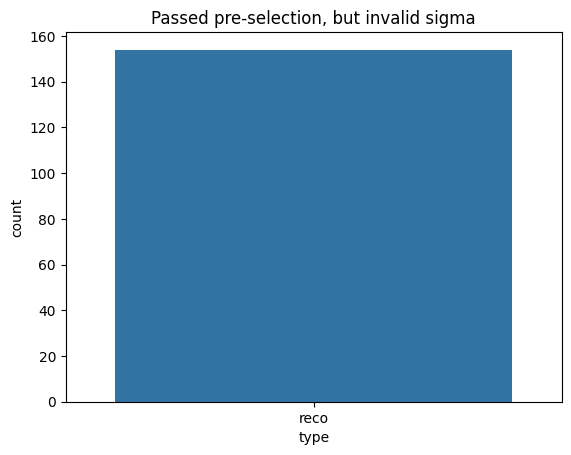

In [11]:
# Passed pre-selection, but still invalid
f = sns.countplot(data=data_split[(data_split["passed_preselection"] == 1) & (data_split["sigma"] == 0)], x="type")
f.set(title="Passed pre-selection, but invalid sigma")

In [12]:
def plot_pplot(title:str, file_prefix:str, data_split, vars=["sigma", "sigmalr", "mz", "phif"]):
    f = sns.pairplot(data_split, hue="type", plot_kws=dict( alpha=0.3 ), corner=True)
    f.fig.suptitle(title, y=1.01)

    #plt.savefig(file_prefix + "_pairplot.pdf")

def plot_hists(title:str, file_prefix:str, data):
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12., 8.)) # layout="constrained"
    fig.suptitle(title)

    cmap = sns.color_palette("Blues", as_cmap=True)

    # Seaborn: unweighted (linear) histograms
    f1 = sns.histplot(data=data, x="true_phif", y="true_mz", bins=(24,64), cbar=True, vmin=0, vmax=250, ax=axs[0][0])
    f1.set(xlim=(-3.142,3.142), ylim=(80,102), title="Unweighted")

    f2 = sns.histplot(data=data, x="reco_phif", y="reco_mz", bins=(24,64), cbar=True, vmin=0, vmax=250, ax=axs[1][0])
    f2.set(xlim=(-3.142,3.142), ylim=(80,102), title="Unweighted")

    # Matplotlib: weighted (log) histograms
    if False:
        x = "true_phif"
        y = "true_mz"
        counts, xedges, yedges, im = axs[0][1].hist2d(data=data, x=x, y=y, cmap=cmap, bins=(24,16), range=[[-3.142,3.142], [80, 102]], norm="log", weights=1/data["true_sigmalr"])
        fig.colorbar(im, ax=axs[0][1], location='right')

        x = "reco_phif"
        y = "reco_mz"
        counts, xedges, yedges, im = axs[1][1].hist2d(data=data, x=x, y=y, cmap=cmap, bins=(24,16), range=[[-3.142,3.142], [80, 102]], norm="log", weights=1/data["reco_sigmalr"])
        fig.colorbar(im, ax=axs[1][1], location='right')

    f3 = sns.histplot(data=data, x="true_phif", y="true_mz", bins=(24,64), cbar=True, vmin=0, ax=axs[0][1], weights=(1/data["true_sigmalr"]) )
    f3.set(xlim=(-3.142,3.142), ylim=(80,102), title="Weighted")

    f4 = sns.histplot(data=data, x="reco_phif", y="reco_mz", bins=(24,64), cbar=True, vmin=0, ax=axs[1][1], weights=(1/data["reco_sigmalr"]) )
    f4.set(xlim=(-3.142,3.142), ylim=(80,102), title="Weighted")

    fig.tight_layout()
    #plt.savefig(file_prefix + "_unwt_vs_wt.pdf")

In [13]:
def plot_legoplot(x, y, xlim, ylim, xbins, ybins):
    fig = plt.figure() #create a canvas, tell matplotlib it's 3d
    ax = fig.add_subplot(111, projection='3d')

    hist, xedges, yedges = np.histogram2d(x, y, bins=(xbins, ybins), range = [xlim, ylim])
    xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:]) -(xedges[1]-xedges[0])

    xpos = xpos.flatten()*1./2
    ypos = ypos.flatten()*1./2
    zpos = np.zeros_like (xpos)

    dx = xedges [1] - xedges [0]
    dy = yedges [1] - yedges [0]
    dz = hist.flatten()

    cmap = cm.get_cmap('tab20') # Get desired colormap - you can change this!
    max_height = np.max(dz)   # get range of colorbars so we can normalize
    min_height = np.min(dz)
    # scale each z to [0,1], and get their rgb values
    rgba = [cmap((k-min_height)/max_height) for k in dz] 

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average')
    #plt.title("X vs. Y Amplitudes for ____ Data")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

    return ax


In [14]:
#import analysis.AtlasStyle

In [16]:
ROOT.kRainBow

55

In [87]:
ROOT.gStyle.SetPalette(ROOT.kViridis)

# See https://root.cern.ch/doc/master/classTColor.html
ROOT.gStyle.SetHistLineColor( 1 )

# https://root.cern.ch/doc/master/classTPaveStats.html
ROOT.gStyle.SetOptStat( int("1110", 10) )

In [131]:
# Styling as per https://ipnp.cz/scheirich/?page_id=277
# AtlasStyle: https://github.com/nickcedwards/python-utils/blob/master/AtlasStyle.py

def plot_legoplot_root(x, y, xlim, ylim, xbins = 40, ybins = 40, title="", name="", labels = ("m_{Z}", "#phi_{f}"), units = ("GeV", ""), colorbar=False, weights = None):
    canv = ROOT.TCanvas("c_name", "c_title", 800, 600)
    hlego = ROOT.TH2I(name, title, xbins, xlim[0], xlim[1], ybins, ylim[0], ylim[1])

    xaxis = hlego.GetXaxis()
    yaxis = hlego.GetYaxis()

    xaxis.SetTitle(labels[0] + (" [" + units[0] + "]" if units[0] != "" else ""))
    yaxis.SetTitle(labels[1] + (" [" + units[1] + "]" if units[1] != "" else ""))

    xaxis.SetTitleOffset(1.7)
    yaxis.SetTitleOffset(1.7)

    xaxis.CenterTitle(1)
    yaxis.CenterTitle(1)

    #fig.FillN(len(x), x, y, 1)
    for i in range(0, len(x)):
        hlego.Fill(x[i], y[i])

    hlego.Draw("LEGO2" + ("Z" if colorbar else ""))

    ROOT.gPad.Update()

    # Adjust statsbox; possible only after drawing
    # See https://root.cern.ch/doc/master/classTPaveStats.html
    statsbox = hlego.FindObject("stats")
    statsbox.SetX1NDC(0.65)
    statsbox.SetX2NDC(0.9)
    statsbox.SetY1NDC(0.7)
    statsbox.SetY2NDC(0.9)

    # Adjust colorbar
    if colorbar:
        cbar = hlego.FindObject("palette")

    #canv.Print(join(source_path, "hist.png"))
    canv.Draw()

    return [canv, hlego]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_name
Warning in <TROOT::Append>: Replacing existing TH1: Plot (Potential memory leak).


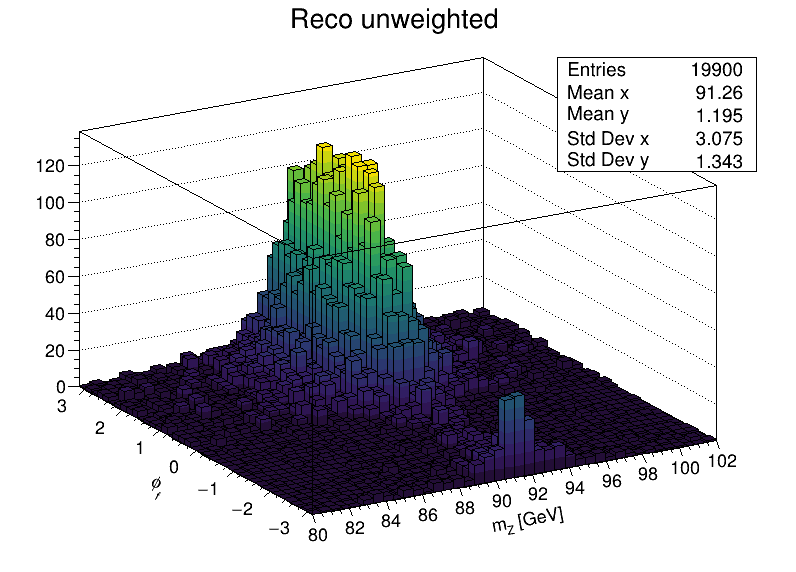

In [132]:
plot_legoplot_root(x=data["reco_mz"], y=data["reco_phif"], xlim=(80, 102), ylim=(-3.142, +3.142), title="Reco unweighted", name="Plot")

<AxesSubplot: ylabel='Count'>

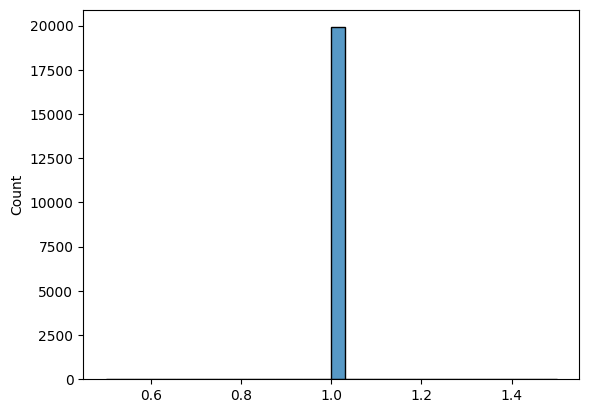

In [19]:
sns.histplot(data["true_sigma"]/data["true_sigma_p1"], bins=32)

<AxesSubplot: ylabel='Count'>

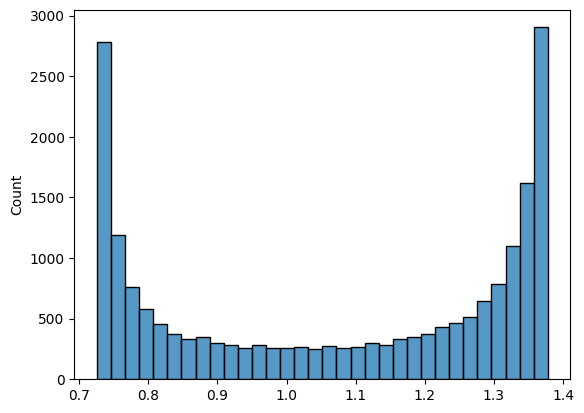

In [18]:
sns.histplot(data["true_sigma"]/data["true_sigma_p2"], bins=32)

<AxesSubplot: ylabel='Count'>

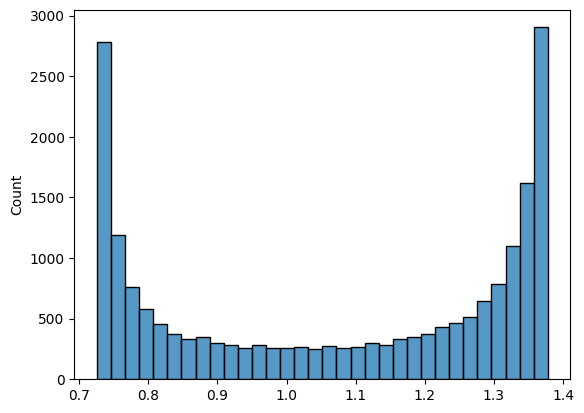

In [17]:
sns.histplot(data["true_sigma"]/data["true_sigma_p3"], bins=32)

In [27]:
#sns.pairplot(data, vars=["true_sigmalr", "true_sigmalr_p1", "true_sigmalr_p2"])

KeyboardInterrupt: 

1. All events / No selection

In [15]:
title = "All events / No preselection"
file_prefix = "1_all_events"
data_current = data

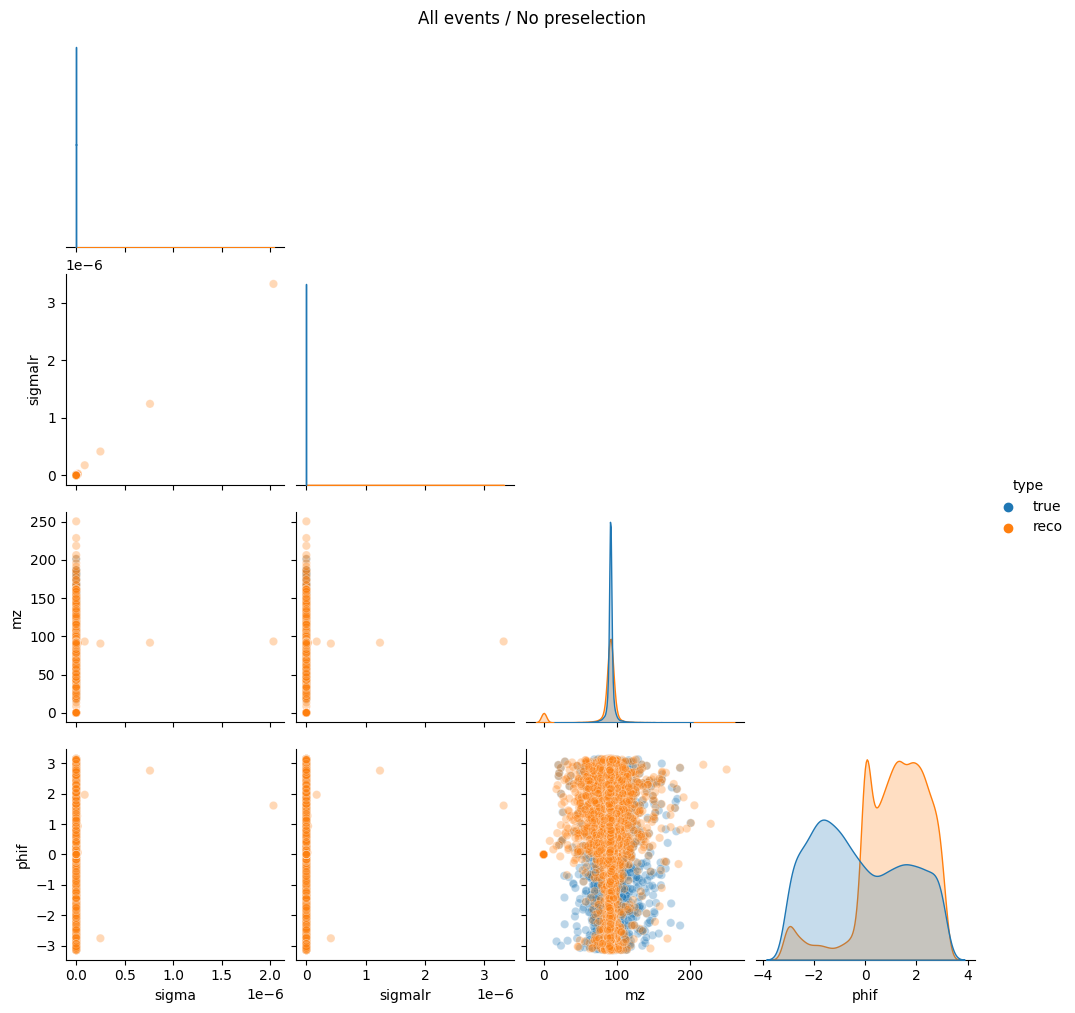

In [16]:
plot_pplot(title, file_prefix, split_event_tree(data_current))

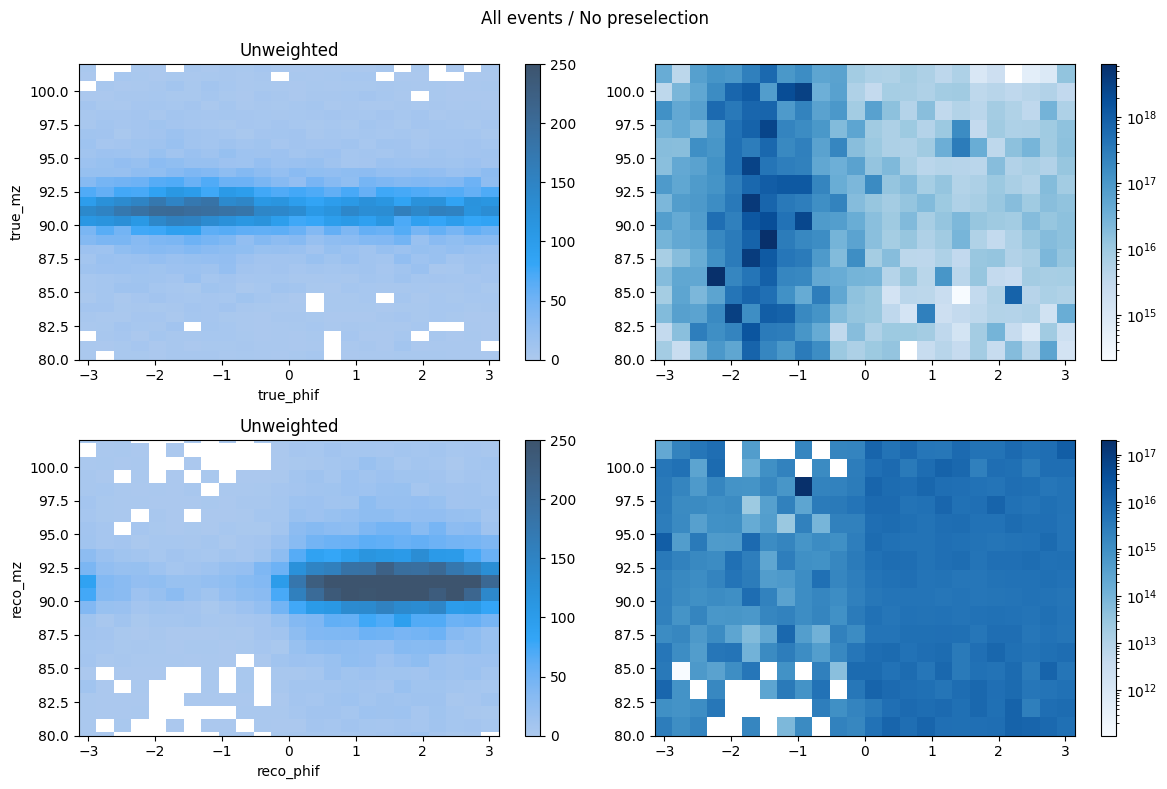

In [48]:
plot_hists(title, file_prefix, data_current)

[(80.0, 102.0), Text(0.5, 1.0, 'ZHH unweighted, both (all events)')]

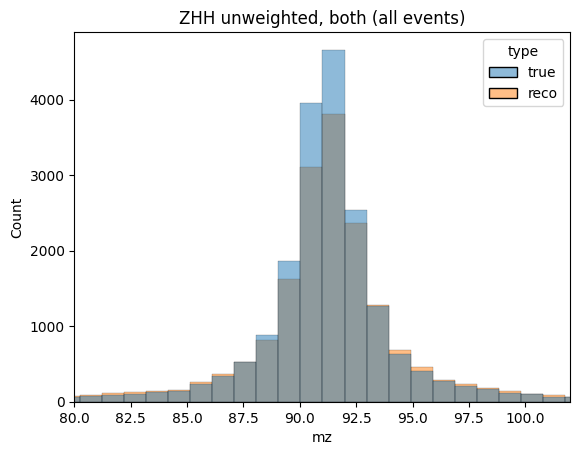

In [49]:
f = sns.histplot(data=data_split, x="mz", bins=256, hue="type", cbar=True)
f.set(xlim=(80,102), title="ZHH unweighted, both (all events)")

In [50]:
np.average(data_split[data_split["type"] == "true"]["sigmalr"])

1.9548625191182865e-14

In [51]:
np.average(data_split[data_split["type"] == "reco"]["sigmalr"])

2.651822206023183e-10

2. Selection A: Passed Pre-Selection (Julie) AND sigma > 0 (Bryan)

In [52]:
title = "Selection A: Passed Pre-Selection AND sigma > 0"
file_prefix = "2_selection_a_passed_presel"
data_current = data[(data["passed_preselection"] == 1) & (data["true_sigma"] > 0) & (data["reco_sigma"] > 0)]

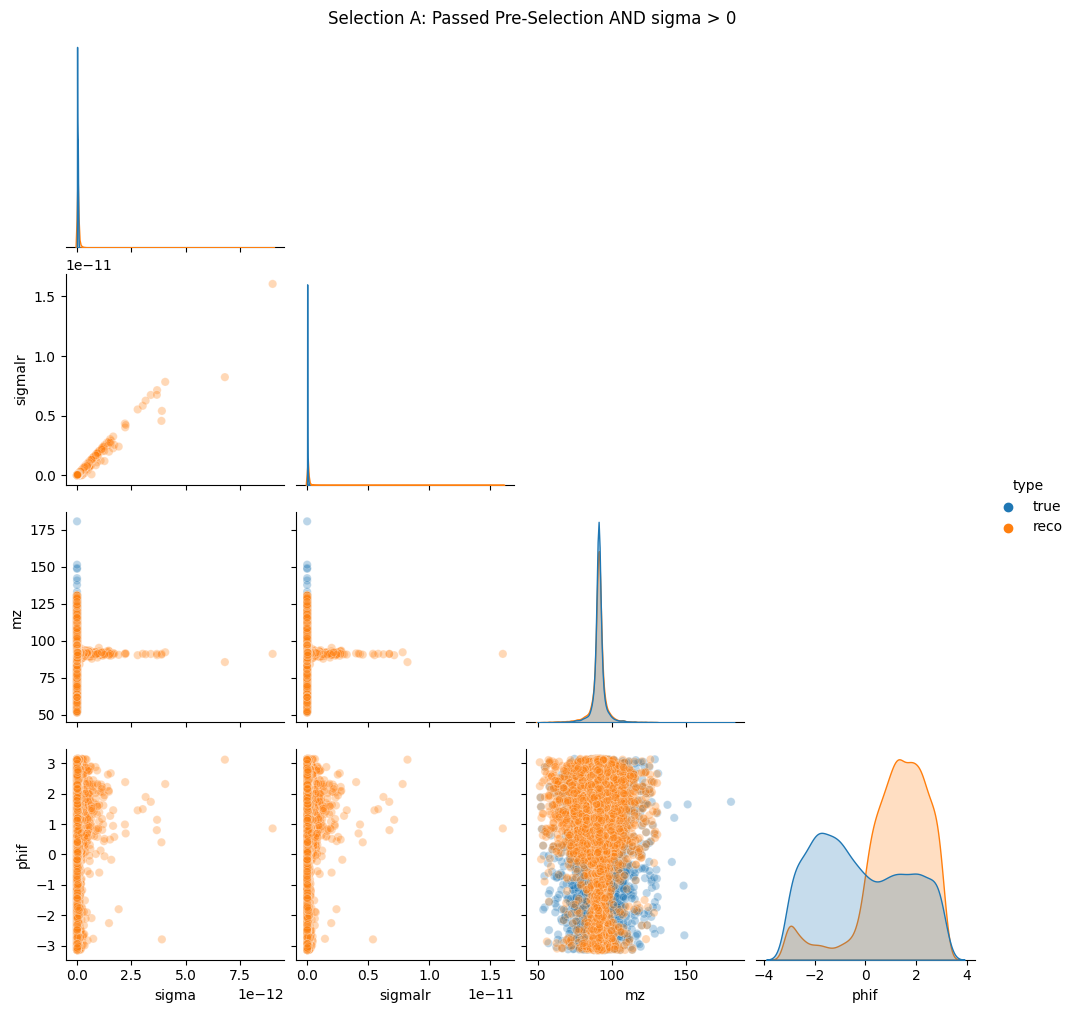

In [53]:
plot_pplot(title, file_prefix, split_event_tree(data_current))

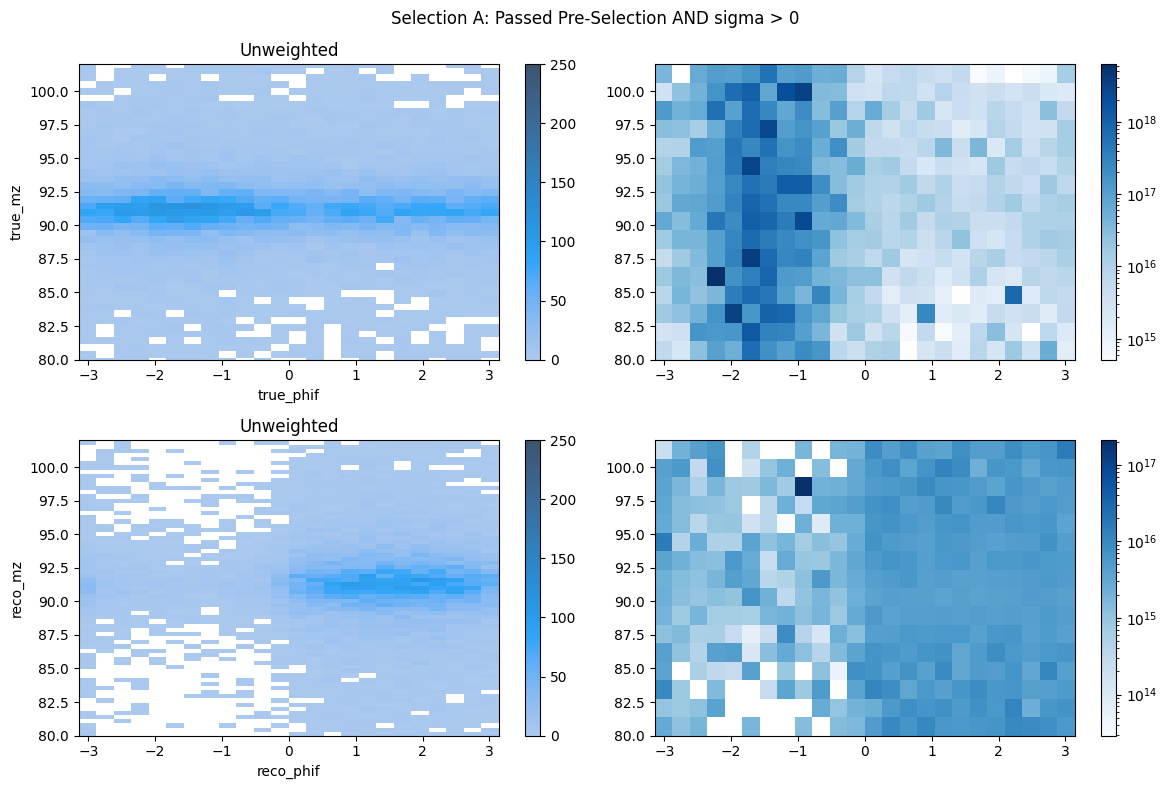

In [54]:
plot_hists(title, file_prefix, data_current)

3. Selection B: Decay to 2b2bbar

In [55]:
title = "Selection B: Decay to 2b2bbar"
file_prefix = "3_selection_b_to_2b2bbar"
data_current = data[(data["m_true_h1_decay_pdg"] == 5) & (data["m_true_h2_decay_pdg"] == 5)]

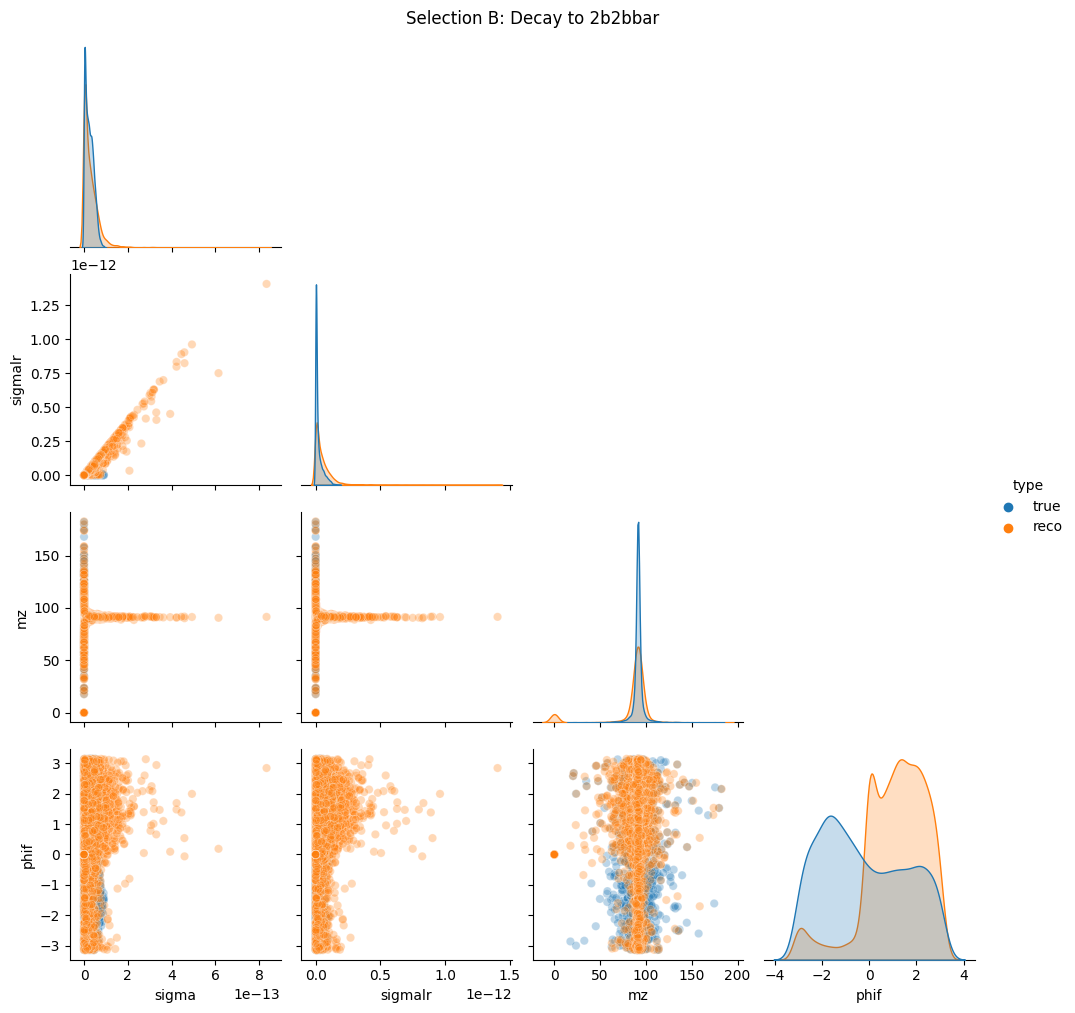

In [56]:
plot_pplot(title, file_prefix, split_event_tree(data_current))

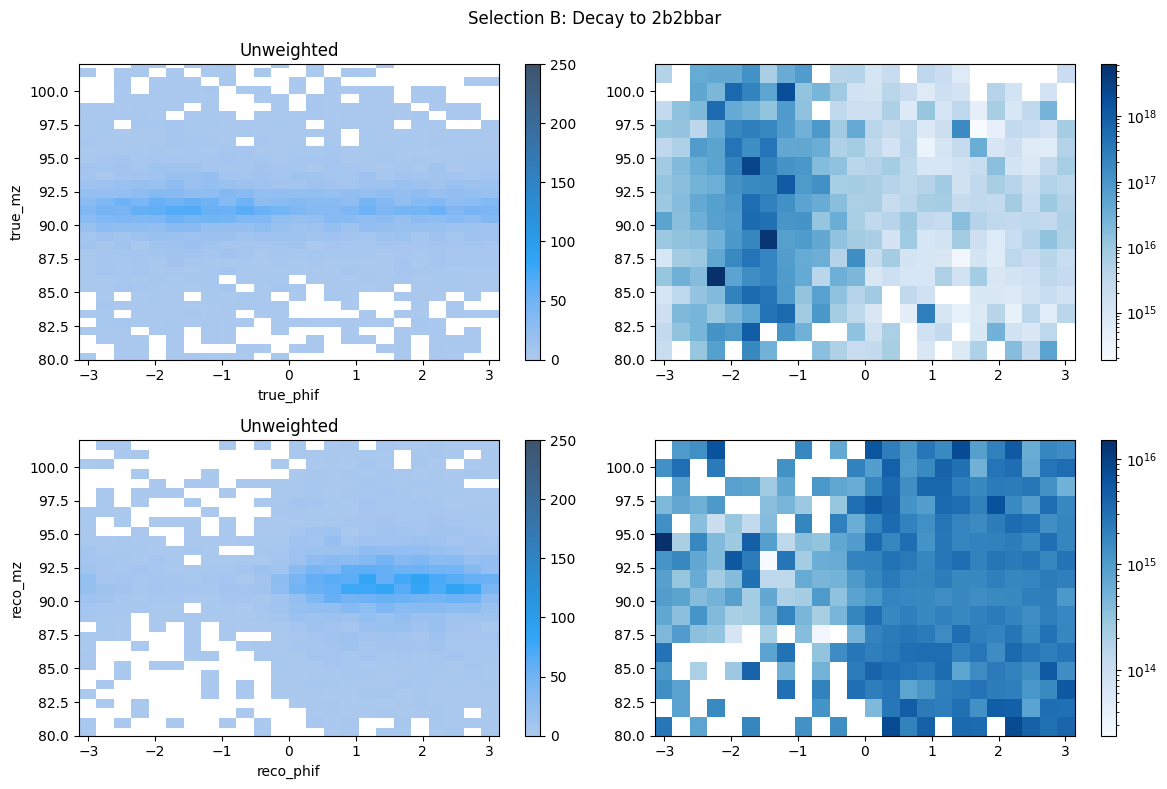

In [57]:
plot_hists(title, file_prefix, data_current)

4. Selection C: Passed Pre-Selection (Julie) AND sigma > 0 (Bryan) AND decay to 2b2bbar

In [14]:
title = "Selection C: Passed Pre-Selection AND Decay to 2b2bbar"
file_prefix = "4_selection_c_passed_presel_and_to_2b2bbar"
data_current = data[(data["passed_preselection"] == 1) & ((data["true_sigma"] > 0) & (data["reco_sigma"] > 0)) & (data["m_true_h1_decay_pdg"] == 5) & (data["m_true_h2_decay_pdg"] == 5)]

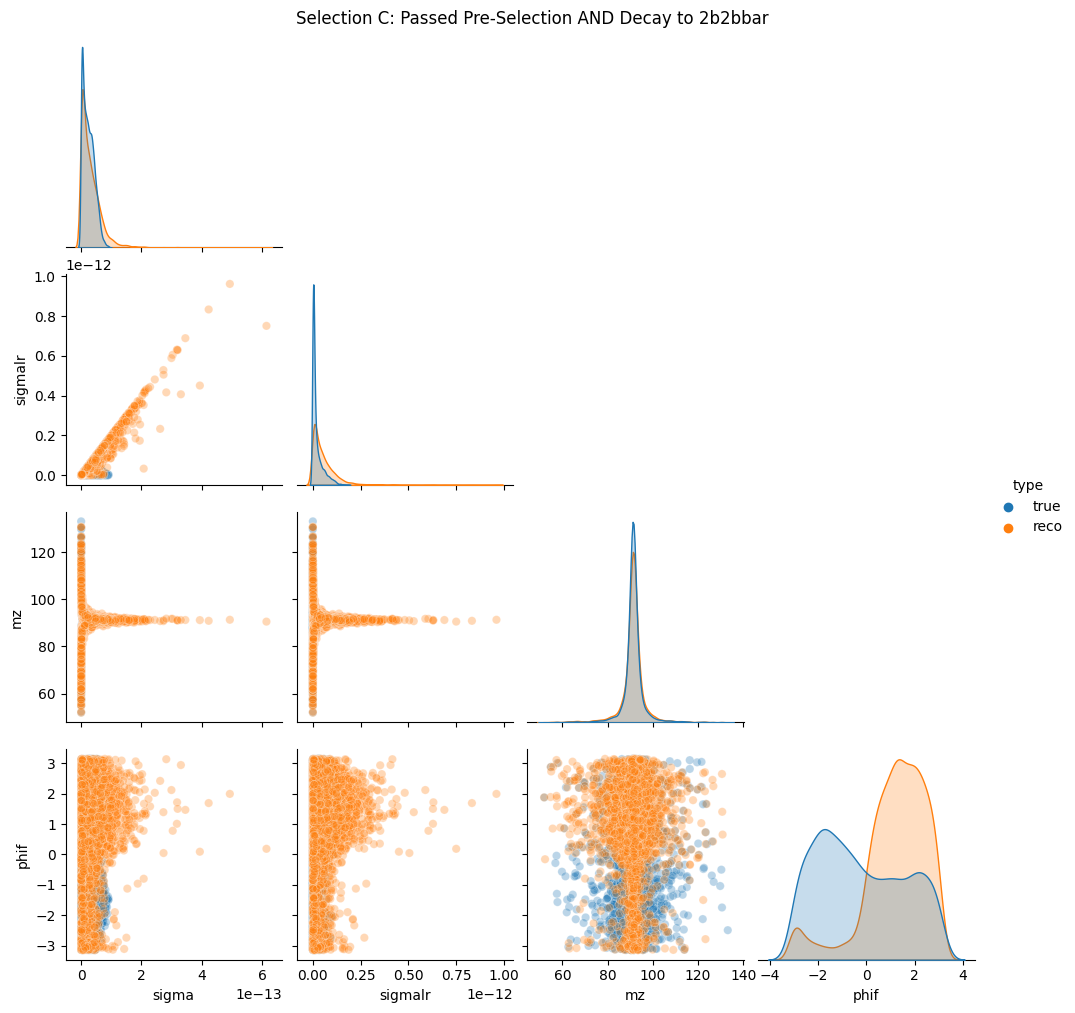

In [15]:
plot_pplot(title, file_prefix, split_event_tree(data_current))

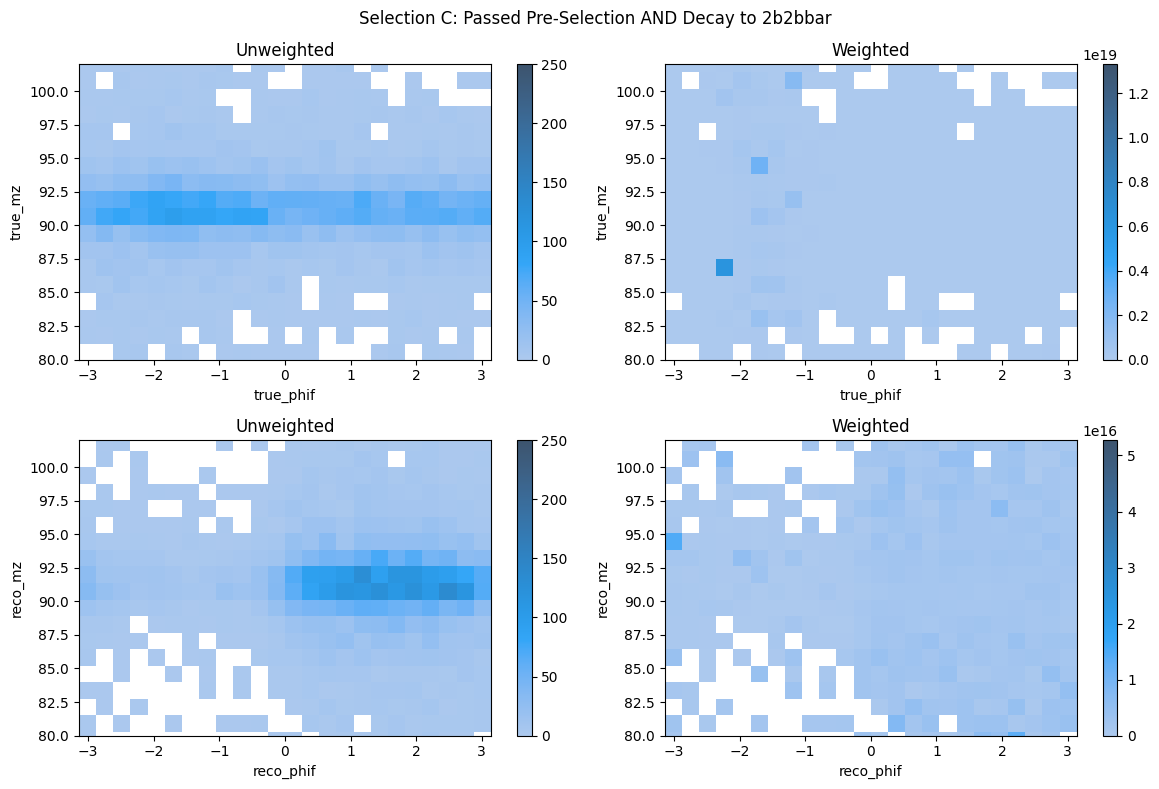

In [16]:
plot_hists(title, file_prefix, data_current)

THE END

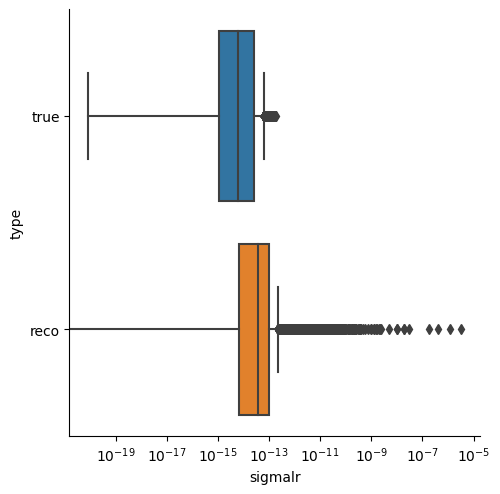

In [97]:
f = sns.catplot(data=data_split, x="sigmalr", y="type", kind="box")
f.set(xscale="log")

In [108]:
f = sns.catplot(data=data_split, x="sigmalr", y="type", kind="swarm")
f.set(xscale="log")

KeyboardInterrupt: 

In [17]:
factor = np.average(data_split[data_split["type"] == "true"]["sigmalr"])/np.average(data_split[data_split["type"] == "reco"]["sigmalr"])
weights = []

for i in range(0, len(data_split)):
    row = data_split.iloc[i]
    weight = row["sigmalr"]

    if row["type"] == "reco":
        weight = weight*factor

    weights.append(0 if weight == 0 else 1/weight)

[Text(0.5, 1.0, 'ZHH weighted, both (all events)')]

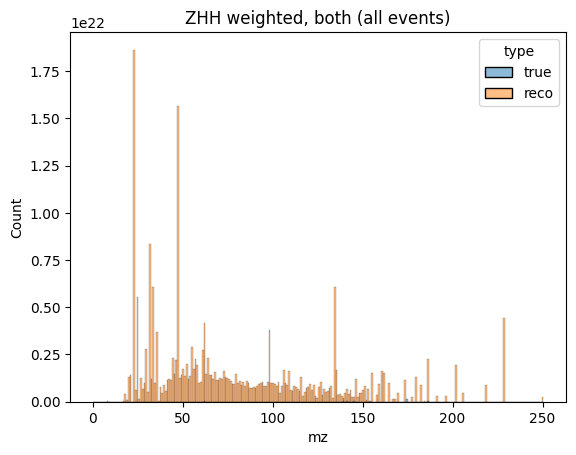

In [62]:
f = sns.histplot(data=data_split, x="mz", bins=256, hue="type", cbar=True, weights=weights)
f.set(title="ZHH weighted, both (all events)")

In [63]:
max(data["reco_phif"])

3.140850067138672

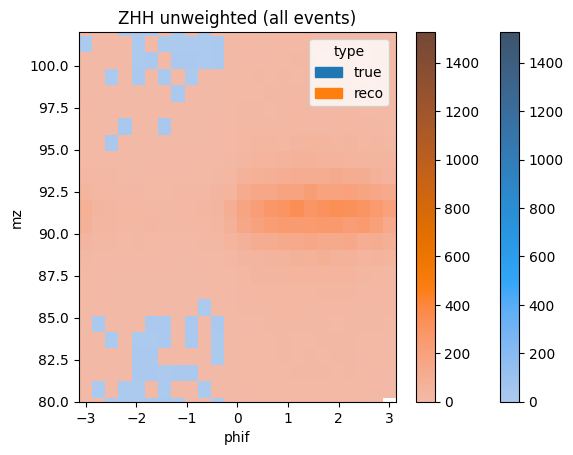

In [64]:
x = "phif"
y = "mz"
f = sns.histplot(data=data_split, x=x, y=y, common_bins=True, bins=(24,256), cbar=True, hue="type")
f.set(xlabel=x, ylabel=y, xlim=(-3.142,3.142), ylim=(80,102), title="ZHH unweighted (all events)")
plt.savefig("1_no_selection_hist_unwt.png")

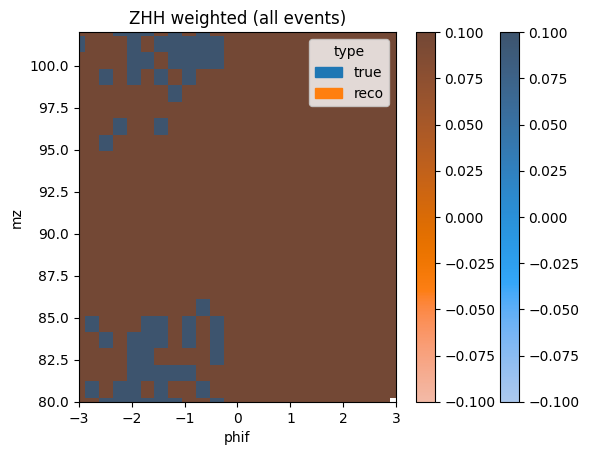

In [65]:
x = "phif"
y = "mz"
f = sns.histplot(data=data_split, x=x, y=y, bins=(24,256), common_bins=True, cbar=True, hue="type", weights=1/data_split["sigmalr"])
f.set(xlabel=x, ylabel=y, xlim=(-3,3), ylim=(80,102), title="ZHH weighted (all events)")
plt.savefig("1_no_selection_hist_wt.png")

In [ ]:
x = "phif"
y = "mz"
f = sns.histplot(data=data_split, x=x, y=y, bins=(24,256), cbar=True, weights=1/data_split["sigmalr"])
f.set(xlabel=x, ylabel=y, xlim=(-3,3), ylim=(80,102), title="ZHH weighted (all events)")

2. Pass Pre-Selection (and sigma > 0)

Text(0.5, 1.08, 'Passed Pre-Selection (and valid sigma > 0)')

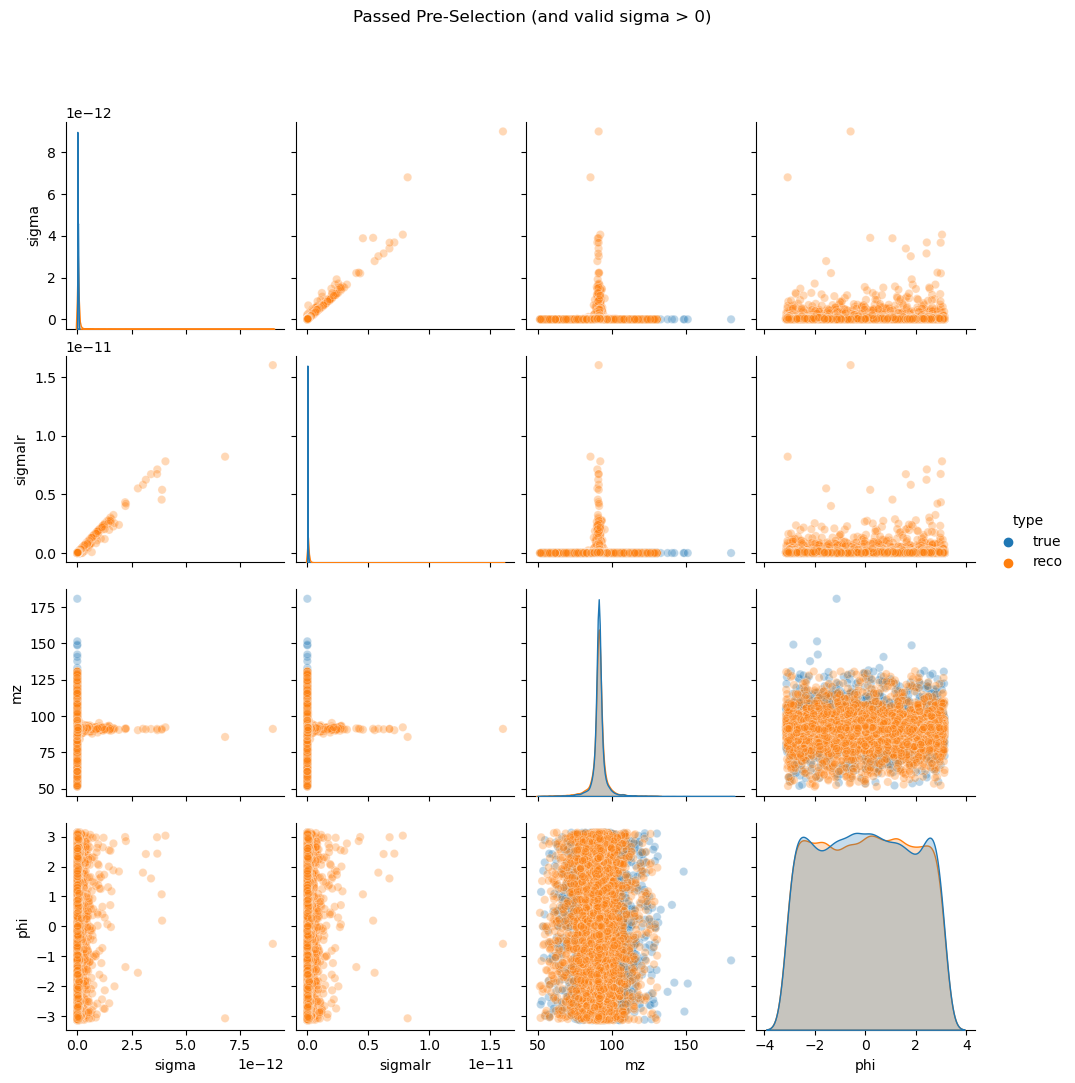

In [22]:
data_split_passed = data_split[(data_split["passed_preselection"] == 1) & (data_split["sigma"] > 0)]

f = sns.pairplot(data_split_passed, hue="type", vars=["sigma", "sigmalr", "mz", "phi"], plot_kws=dict( alpha=0.3 ))
f.fig.suptitle("Passed Pre-Selection (and valid sigma > 0)", y=.5)

In [12]:
print(data_split.shape, data_split_passed.shape)

(39800, 16) (31989, 16)


In [10]:
data[data["reco_sigma"] == 0].shape

(1526, 25)

[Text(0.5, 1.0, 'passed_preselection')]

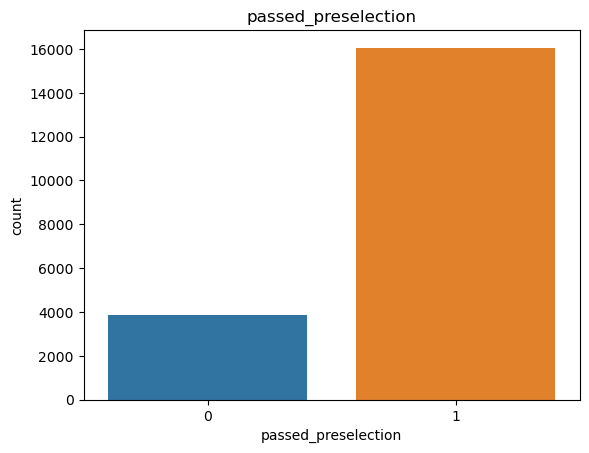

In [114]:
x = "passed_preselection"

#fig, axs = plt.subplots(ncols=3)
#f = sns.countplot(data, x=x1, ax=axs[0])
f = sns.countplot(data, x=x)
f.set(title=x)

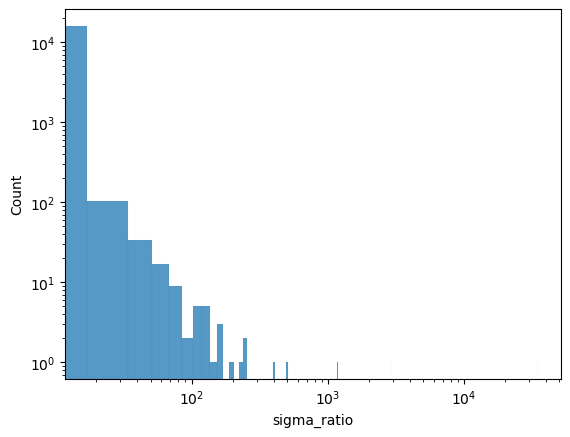

In [141]:
x = "sigma_ratio"

f = sns.histplot(data=data[data["passed_preselection"] == 1], x=x, bins=2048)
f.set_yscale("log")
f.set_xscale("log")

In [116]:
data.head()

,run,event,passed_preselection,m_true_h1_decay_pdg,m_true_h2_decay_pdg,true_sigma,true_sigmall,true_sigmalr,true_sigmarl,true_sigmarr,...,reco_mhh,reco_mzhh,reco_phi,reco_costheta,sigma_ratio,mz_ratio,true_phi_wt,reco_phi_wt,true_mz_wt,reco_mz_wt
0,403001,1,1,5,5,4.069340e-14,3.552943e-15,7.860422e-14,7.876372e-14,1.852726e-15,...,307.026154,446.901337,-3.079209,0.658341,2.008289,1.005754,-3.638463e+13,-1.924244e+13,1.152185e+15,5.692205e+14
1,403001,2,1,21,5,7.931965e-14,2.042705e-13,2.737472e-15,2.752175e-15,1.075185e-13,...,299.286835,425.062439,-1.075820,0.002598,0.996751,0.993437,-6.055578e+14,-6.918456e+12,3.347196e+16,5.853838e+14
2,403001,3,1,5,5,2.001587e-14,1.842408e-14,2.597875e-14,2.596317e-14,9.697490e-15,...,309.041565,483.490875,-1.056400,0.899296,1.798155,1.006597,-4.435455e+13,-2.224379e+13,3.472427e+15,1.911997e+15
3,403001,4,1,5,24,2.711904e-16,7.092752e-16,1.012994e-18,1.001357e-18,3.734722e-16,...,367.116302,472.364105,-1.489111,-0.203174,0.476201,0.999254,1.372745e+17,-5.929084e+15,7.168607e+19,2.889204e+17
4,403001,5,1,5,5,7.656955e-16,1.376326e-17,1.521178e-15,1.520468e-15,7.372861e-18,...,301.307892,435.992157,2.496945,0.643037,1.694688,1.003574,1.591160e+15,9.709764e+14,5.336387e+16,3.167936e+16


[Text(0.5, 0, 'true_phif'),
 Text(0, 0.5, 'true_mz'),
 (-3.0, 3.0),
 (80.0, 102.0)]

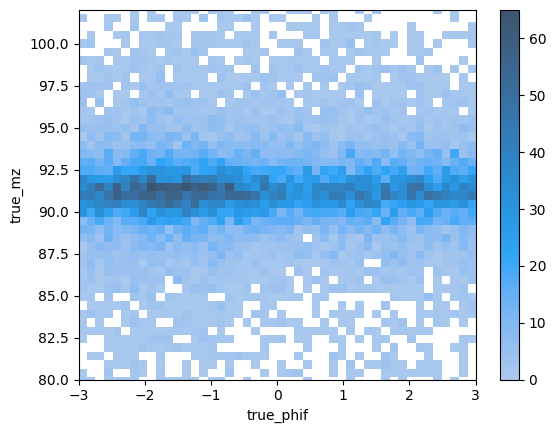

In [12]:
x = "true_phif"
y = "true_mz"

f = sns.histplot(data=data[data["passed_preselection"] == 1], x=x, y=y, bins=(48,256), cbar=True)
f.set(xlabel=x, ylabel=y, xlim=(-3,3), ylim=(80,102))

[Text(0.5, 0, 'true_phif'),
 Text(0, 0.5, 'true_mz'),
 (-3.0, 3.0),
 (80.0, 102.0)]

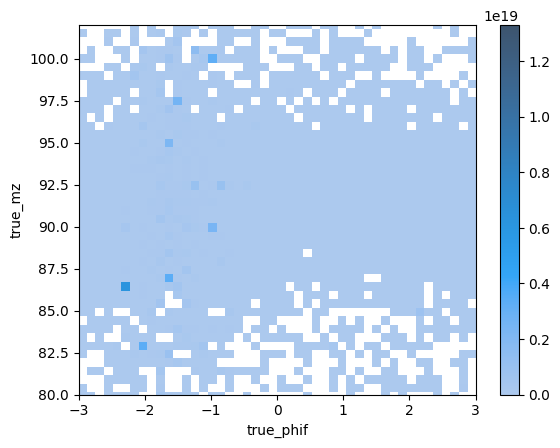

In [13]:
x = "true_phif"
y = "true_mz"

f = sns.histplot(data=data[data["passed_preselection"] == 1], x=x, y=y, bins=(48,256), cbar=True, weights=1/data["true_sigmalr"])
f.set(xlabel=x, ylabel=y, xlim=(-3,3), ylim=(80,102))

In [20]:
factor

7.37177068160201e-05

[Text(0.5, 0, 'reco_phi'), Text(0, 0.5, 'reco_mz'), (-3.0, 3.0), (80.0, 102.0)]

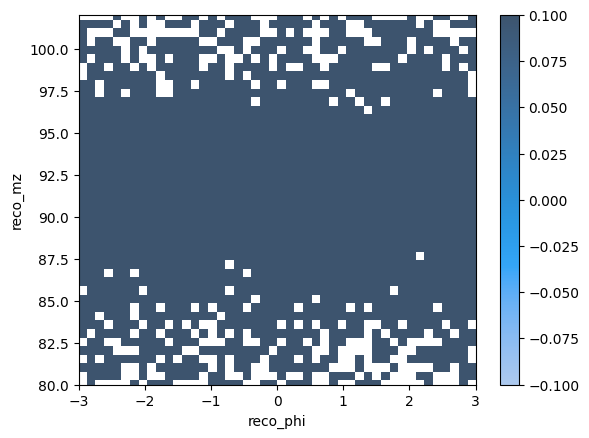

In [28]:
x = "reco_phi"
y = "reco_mz"

f = sns.histplot(data=data[data["passed_preselection"] == 1], x=x, y=y, bins=(48,256), weights=1/data["reco_sigmalr"], cbar=True)
f.set(xlabel=x, ylabel=y, xlim=(-3,3), ylim=(80,102))

In [1]:
data_zhh = pd.DataFrame(np.load(b[3], allow_pickle=True))
data_zhh["type"] = "zhh"
data_zhh.columns

NameError: name 'pd' is not defined

<Axes: xlabel='actual_zdecay_pdg', ylabel='count'>

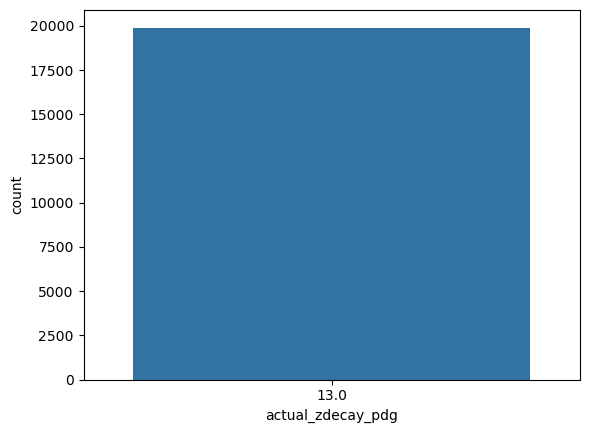

In [84]:
sns.countplot(data_zhh, x="actual_zdecay_pdg")

In [85]:
data = pd.concat([data_zzh, data_zhh])

In [86]:
data.columns

Index(['sigma', 'sigmalll', 'sigmallr', 'sigmalrl', 'sigmalrr', 'sigmarll',
       'sigmarlr', 'sigmarrl', 'sigmarrr', 'mzz', 'mz1', 'mz2', 'mzzh',
       'costheta', 'phi', 'costhetaz', 'phiz', 'costhetaz1f', 'phiz1f',
       'costhetaz2f', 'phiz2f', 'corr_pdgs', 'actual_z1decay_pdg',
       'actual_z2decay_pdg', 'type', 'sigmall', 'sigmarl', 'sigmalr',
       'sigmarr', 'mz', 'mhh', 'mzhh', 'costhetaf', 'phif', 'costhetah',
       'phih', 'actual_zdecay_pdg'],
      dtype='object')

[Text(0.5, 0, 'sigma')]

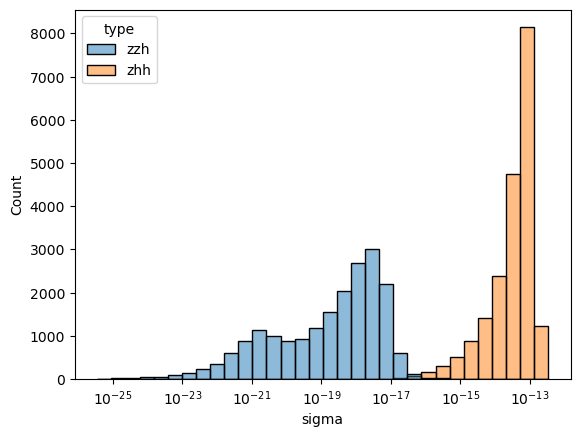

In [87]:
x = "sigma"
f = sns.histplot(data, x=x, hue="type", bins=32, log_scale=True)
f.set(xlabel=x)

[Text(0.5, 0, 'sigma'), Text(0.5, 1.0, 'zhh')]

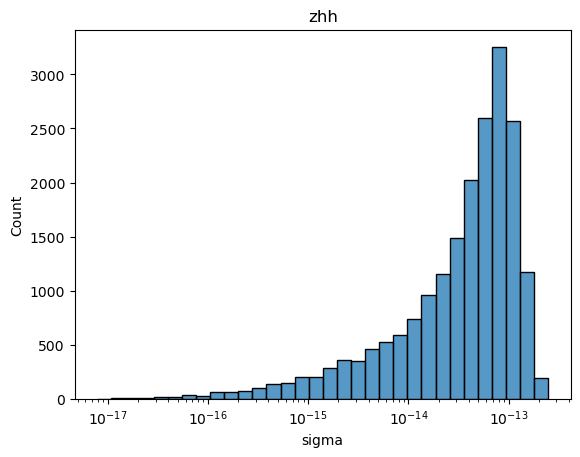

: 

In [88]:
x = "sigma"
f = sns.histplot(data[data["type"] == "zhh"], x="sigma", bins=32, log_scale=True)
f.set(xlabel=x, title="zhh")

[Text(0.5, 0, 'sigma'), Text(0.5, 1.0, 'zzh; assuming Z2 to bbar')]

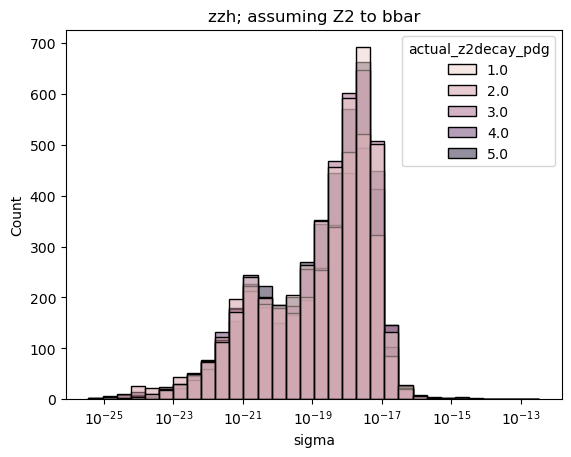

In [56]:
x = "sigma"
f = sns.histplot(data[data["type"] == "zzh"], x="sigma", hue="actual_z2decay_pdg", bins=32, log_scale=True)
f.set(xlabel=x, title="zzh; assuming Z2 to bbar")

[Text(0.5, 0, 'sigma'), Text(0.5, 1.0, 'zzh mz1,mz2')]

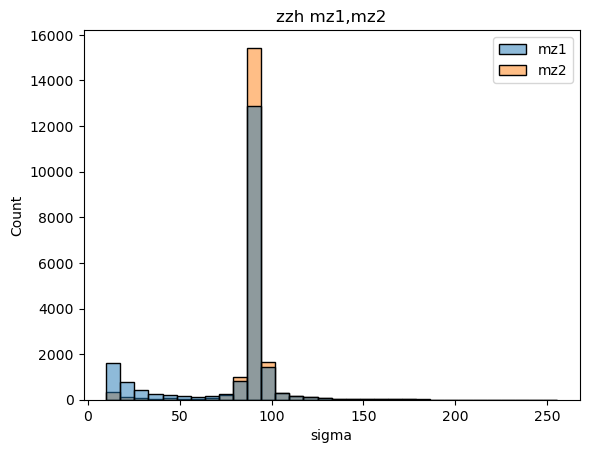

In [76]:
x = "sigma"
y = ["mz1", "mz2"]
f = sns.histplot(data[data["type"] == "zzh"][y], bins=32)
f.set(xlabel=x, title="zzh " + ",".join(y))

[Text(0.5, 0, 'mz1'), Text(0.5, 1.0, 'zzh; assuming Z2 to bbar'), None]

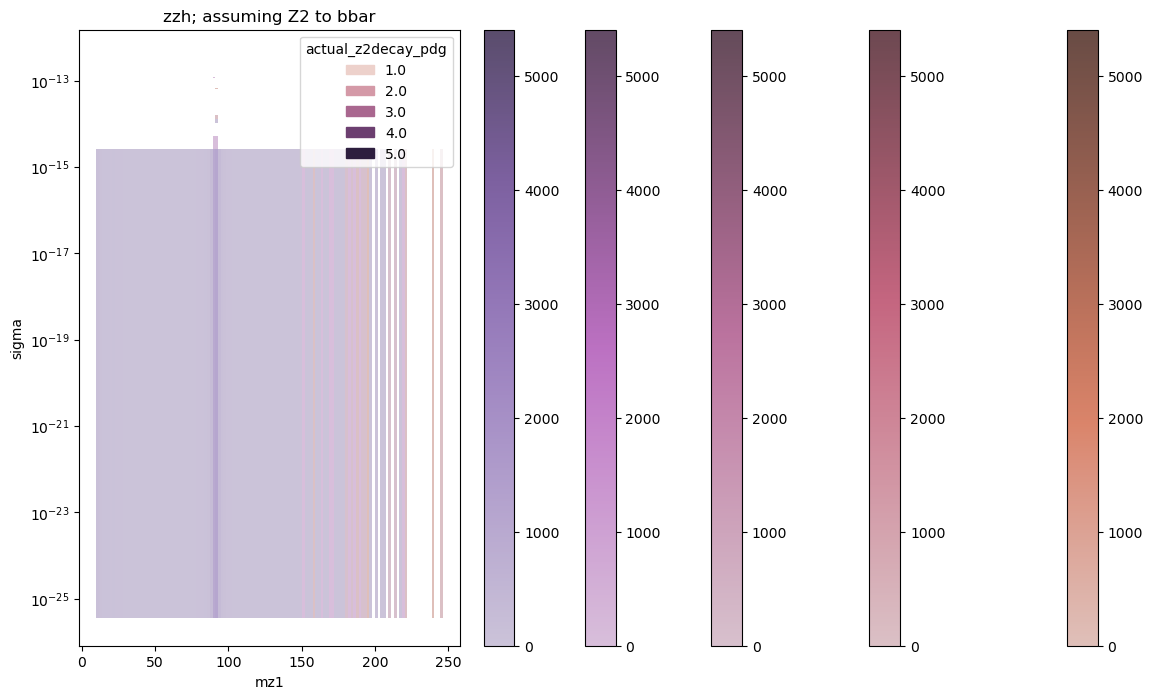

In [74]:
x = "mz1"
y = "sigma"

plt.figure(figsize=(15,8))
f = sns.histplot(data[data["type"] == "zzh"], x=x, y=y, hue="actual_z2decay_pdg", bins=128, cbar=True)
f.set(xlabel=x, title="zzh; assuming Z2 to bbar", yscale="log")

[Text(0.5, 0, 'mz'), Text(0.5, 1.0, 'Pe2e2hh.eL.pR / ZHH')]

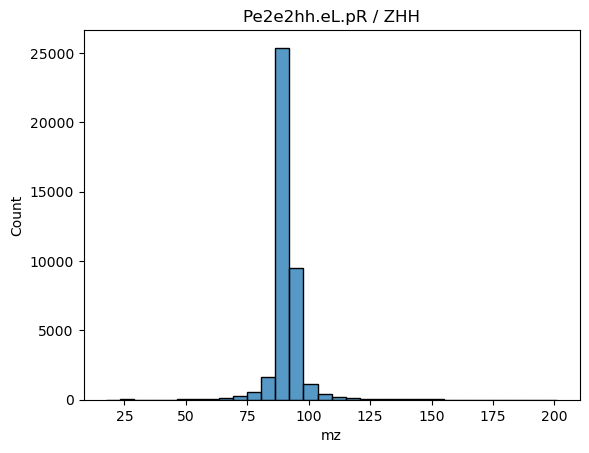

In [59]:
x = "mz"
f = sns.histplot(x=data[x], bins=32)
f.set(xlabel=x, title="Pe2e2hh.eL.pR / ZHH")

[Text(0.5, 0, 'mhh'), Text(0.5, 1.0, 'Pe2e2ffqqH.eL.pR / ZHH')]

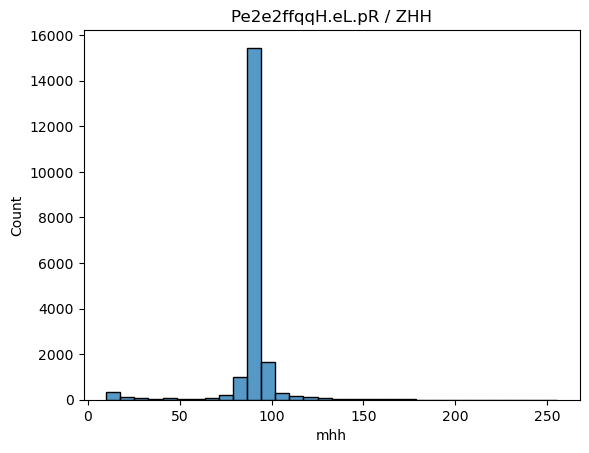

In [15]:
x = "mhh"
f = sns.histplot(x=data[x], bins=32)
f.set(xlabel=x, title="Pe2e2ffqqH.eL.pR / ZHH")

[Text(0.5, 0, 'phif'),
 Text(0, 0.5, 'mz'),
 (-3.0, 3.0),
 (80.0, 102.0),
 Text(0.5, 1.0, 'Pe2e2hh.eL.pR / ZHH unweighted')]

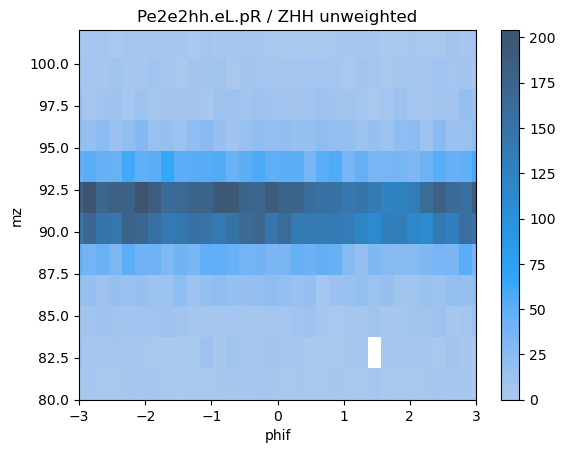

In [16]:
x = "phif"
y = "mz"
f = sns.histplot(x=data[x], y=data[y], bins=(32,128), cbar=True)
f.set(xlabel=x, ylabel=y, xlim=(-3,3), ylim=(80,102), title="Pe2e2hh.eL.pR / ZHH unweighted")

[Text(0.5, 0, 'sigmalr'), Text(0.5, 1.0, 'Pe2e2hh.eL.pR'), None]

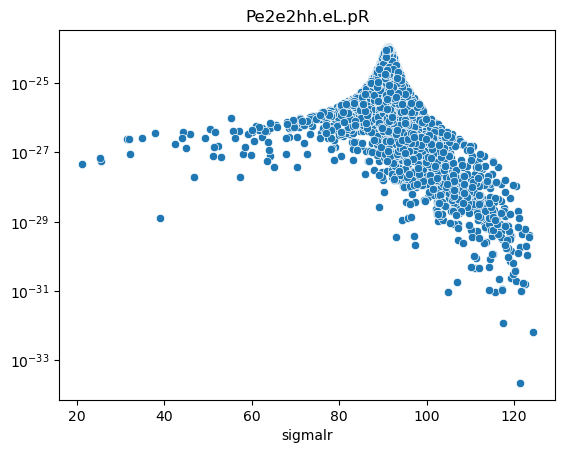

In [34]:
x = "sigmalr"
f = sns.scatterplot(x=data_old["mz"], y=data_old[x])
f.set(xlabel=x, title="Pe2e2hh.eL.pR", yscale="log")

[Text(0.5, 0, 'sigmalr'), Text(0.5, 1.0, 'Pe2e2hh.eL.pR'), None]

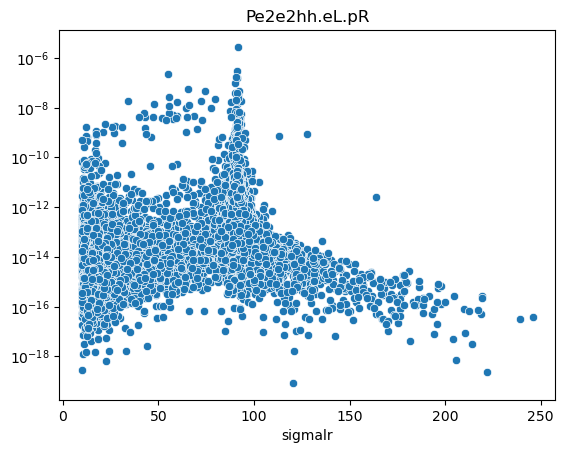

In [35]:
x = "sigmalr"
f = sns.scatterplot(x=data["mz"], y=data[x])
f.set(xlabel=x, title="Pe2e2ffqqh.eL.pR CORRECT", yscale="log")

[Text(0.5, 0, 'sigmalr'), Text(0.5, 1.0, 'Pe2e2ffqqh.eL.pR CORRECT'), None]

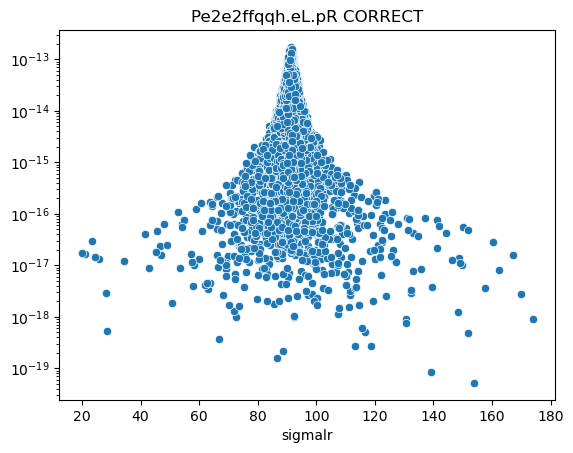

In [37]:
x = "sigmalr"
f = sns.scatterplot(x=data_inv["mz"], y=data_inv[x])
f.set(xlabel=x, title="Pe2e2ffqqh.eL.pR CORRECT", yscale="log")

[Text(0.5, 0, 'phif'),
 Text(0, 0.5, 'mz'),
 Text(0.5, 1.0, 'Pe2e2hh.eL.pR / ZHH weighted by sigmalr')]

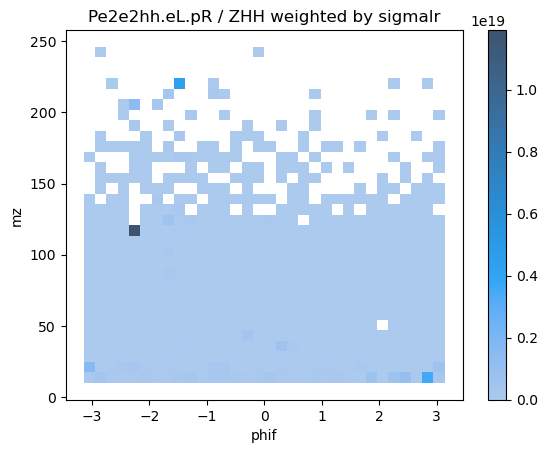

In [13]:
x = "phif"
y = "mz"
weight = "sigmalr"
f = sns.histplot(x=data[x], y=data[y], bins=32, cbar=True, weights=1/data[weight])
f.set(xlabel=x, ylabel=y, title="Pe2e2hh.eL.pR / ZHH weighted by " + weight)